# Install Requirements

In [1]:
%pip install transformers datasets
%pip install torch
%pip install matplotlib
%pip install umap-learn numba==0.48.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached numba-0.48.0.tar.gz (2.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached llvmlite-0.31.0.tar.gz (110 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.2.tar.gz (86 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.1.tar.gz (80 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.0.tar.gz (81 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap_learn-0.4.6-py3-none-any.whl
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [755 lines of output]
      /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-install-9w3wjdjf/numba_3ce053275a9a4ba3b8428433db27acbd/setup.py:98: DeprecationWarning:
      
        `

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load Language Model

In [3]:
#MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled" # NL MODEL TODO: is the model trained on lowercased data?

MODEL_NAME = "roberta-base"

#MODEL_NAME = "xlm-roberta-base" # cross-lingual mode (https://huggingface.co/xlm-roberta-base)


In [4]:
from transformers import RobertaModel, AutoTokenizer, RobertaPreTrainedModel, BertModel, GPT2Model, pipeline
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#model = RobertaModel.from_pretrained(MODEL_NAME)

# FIXME: cannot use pipeline for extracting layers other than the last one
model: FeatureExtractionPipeline = pipeline('feature-extraction', model=MODEL_NAME, tokenizer=tokenizer)

/Users/carstenschnober/opt/anaconda3/envs/SoS/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Load Data

In [5]:
from pathlib import Path

DATA_DIR = Path.cwd() / "data"

## SemEval 2020 (C)COHA corpus

### Download

In [6]:
from io import BytesIO
from zipfile import ZipFile
import urllib

SEMEVAL_DATA_URL = "https://www2.ims.uni-stuttgart.de/data/sem-eval-ulscd/semeval2020_ulscd_eng.zip"

SEMEVAL2020_DIR = DATA_DIR / "semeval2020_ulscd_eng"

if SEMEVAL2020_DIR.is_dir():
    print(f"Directory '{SEMEVAL2020_DIR}' already exists, skipping corpus download.")
else:
    with urllib.request.urlopen(SEMEVAL_DATA_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(DATA_DIR)

assert SEMEVAL2020_DIR.is_dir(), f"Directory does not exist: '{SEMEVAL2020_DIR}'"


Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/semeval2020_ulscd_eng' already exists, skipping corpus download.


In [7]:
CORPUS1_DIR = SEMEVAL2020_DIR / 'corpus1'
CORPUS2_DIR = SEMEVAL2020_DIR / 'corpus2'
TRUTH_DIR = SEMEVAL2020_DIR / 'truth'

assert CORPUS1_DIR.is_dir(), f"Directory does not exist: '{CORPUS1_DIR}'"
assert CORPUS2_DIR.is_dir(), f"Directory does not exist: '{CORPUS2_DIR}'"
assert TRUTH_DIR.is_dir(), f"Directory does not exist: '{TRUTH_DIR}'"


### Read

In [8]:
TOKENS_FILE1 = CORPUS1_DIR / "token" / "ccoha1.txt.gz"
TOKENS_FILE2 = CORPUS2_DIR / "token" / "ccoha2.txt.gz"

assert TOKENS_FILE1.is_file()
assert TOKENS_FILE2.is_file()

In [9]:
import gzip

with gzip.open(TOKENS_FILE1, 'rt') as f:
    sentences_1810 = f.readlines()

assert len(sentences_1810) == 253644

with gzip.open(TOKENS_FILE2, 'rt') as f:
    sentences_1960 = f.readlines()

assert len(sentences_1960) == 353692

## COHA Corpus (Sample)

### Download

In [10]:
#COHA_DATABASE_URL = 'https://www.corpusdata.org/coha/samples/database.zip'
COHA_TEXT_URL = 'https://www.corpusdata.org/coha/samples/text.zip'

COHA_DIR = DATA_DIR / "COHA"

try:
    COHA_DIR.mkdir(parents=True, exist_ok=False)
except OSError as e:
    print(f"Directory '{COHA_DIR}' already exists: {str(e)}. Skipping corpus download.")
else:
    with urllib.request.urlopen(COHA_TEXT_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(COHA_DIR)

assert COHA_DIR.is_dir()

Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA' already exists: [Errno 17] File exists: '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA'. Skipping corpus download.


### Read

In [11]:
from functools import cached_property
import logging
import re
from typing import Generator, List

FILENAME_PATTERN = r"([a-z]{2,4})_(\d{4})_(\d{3,6})\.txt"
SENTENCE_PATTERN = r"\s*(.*?\s[\.!?\n])"

class CohaDoc:
    _encoding = 'UTF-8'

    def __init__(self, path: Path):
        self._path = path

        try:
            genre, year, id = re.search(FILENAME_PATTERN, self._path.name).groups()
        except AttributeError as e:
            raise ValueError(f"Could not parse path: '{path}': {str(e)}")
        
        self._genre = genre
        self._year = int(year)
        self._id = int(id)

    def __repr__(self) -> str:
        return str(self._path.name)

    @property
    def genre(self) -> str:
        return self._genre

    @property
    def year(self) -> int:
        return self._year

    @property
    def id(self) -> int:
        return self._id
    
    @cached_property
    def text(self):
        with open(self._path, 'rt', encoding=self._encoding) as f:
            return f.read()

    def sentences(self):
        sentences = re.findall(SENTENCE_PATTERN, self.text)
        assert sentences[0].strip() == f"@@{self._id}", f"First line is expected to match document ID ('{self._id}'), but is: {sentences[0]}"
        return sentences[1:]

    def find_sentences(self, term: str) -> List[str]:
        return [
            sentence
            for sentence in self.sentences()
            if term in sentence
        ]
        
    def clean_sentences(self):
        # TODO
        return NotImplemented


In [12]:
coha_docs = [CohaDoc(file) for file in COHA_DIR.glob('*.txt')]

assert len(coha_docs) == 1144

(array([ 12.,  13.,  24.,  50.,  60., 156., 206., 188., 247., 188.]),
 array([1817. , 1836.2, 1855.4, 1874.6, 1893.8, 1913. , 1932.2, 1951.4,
        1970.6, 1989.8, 2009. ]),
 <BarContainer object of 10 artists>)

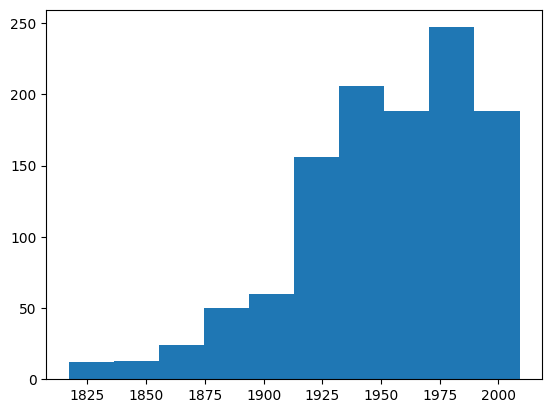

In [13]:
plt.hist([c.year for c in coha_docs])

(array([586.,   0.,   0., 424.,   0.,   0., 108.,   0.,   0.,  26.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

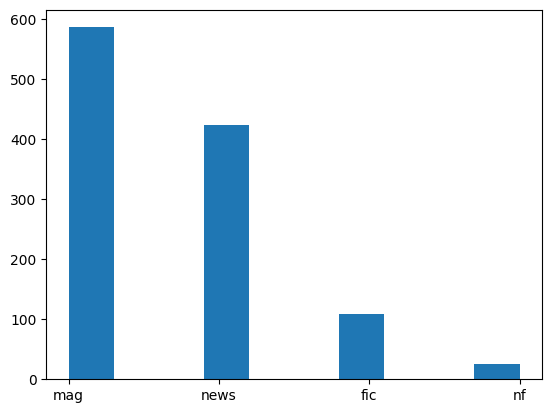

In [14]:
plt.hist([c.genre for c in coha_docs])

# Embeddings

## COHA

In [43]:
TERM1 = 'New York'
TERM2 = 'Philadelphia'

In [44]:

from tqdm import tqdm


for doc in tqdm(coha_docs, unit='doc'):
    if matches := doc.find_sentences(TERM1):
        print(doc)
        print(matches)


  4%|▍         | 44/1144 [00:00<00:05, 214.11doc/s]

news_1953_715250.txt
['House Republican leaders are backing Representative W. Sterling Cole of upstate New York and Senate leaders are supporting , Senator Bourke Hickenlooper of Iowa .']
fic_1979_10650.txt
['Employed by a clothing manufacturer , they were models working out of New York .', 'At the pool , they socialized with wizards of industry and finance , designers from Malibu and Big Sur , political impresariosand their cronies from Washington and New York , the sharks of Palm Beach bridge and backgammon tournaments .', 'Far removed , to New York and New England @ @ @ @ @ @ @ @ @ @ , preoccupied with the children of thesep157unions , they had scant time for Stella , their first daughter , now grown , on the brink of womanhood .', 'He looked like a New York actor , " she laughed.  | " What did he say ?', "I visited him last week in L.A. Otherwise I 'm stillliving in New York .", 'He had seen her in the city twice in June and again in July ; had come to New York for two-day visits .

 21%|██        | 236/1144 [00:00<00:01, 528.74doc/s]

news_1916_682550.txt
['Besides the New York , New Jersey , and Massachusetts troops starting for the border tonight or tomorrow , there will be three brigades of infantry .', "Thus far the man for the New York troops ' entraining tonight to go direct to Brownsville , the apea. of the great ' triangle ofli Texas land that Juts into Mwcico , have not been changed .", "and it is ' reported that the New Jersey and MaSsachusetts Guards will go @ @ @ @ @ @ @ @ @ @ that , General Funston places in the New York , New Jersey ."]
news_1987_670150.txt
['" In many shoe stores , Easter can be the biggest week of the year , " said Harold Sells , chairman and chief executive officer of the New York-based retailer .', 'Same-store sales at New York-based J.C. Penney Co. declined 1. 5% ; at Mercantile Stores Co. @ @ @ @ @ @ @ @ @ @ Dayton-Hudson Corp. , based in Minneapolis , 4. 9% from last year .', '" Fabian Linden , at the Conference Board , a New York-based research organization , said a 1986 car-bu

 44%|████▍     | 503/1144 [00:00<00:00, 714.26doc/s]

fic_2000_30250.txt
['Elizabeth taught in a boarding school in New York .']
fic_1981_780050.txt
['" A waiter delivered a bottle of New York champagne in a bucket , opened it and poured some into each of their glasses .', "They talked about music , the season 's concert activity in Washington and considered going to New York later in the year , if Lydia could free up the time , to catch some Broadway theater and just be together .", "He 'd just received a new shipment from Wendley in New York .", 'London and Spiegel in New York have one theory , Borne in Pennsylvania another .', 'Lydia pushed through that same crowd and watched the back of the apricot coat go up to a waiting bus that said New York .', "And I could n't help but think of the Jean Harris case in New York .", '" " Yes , to New York , to stay with some friends .', "He 'd heard Lydia say that Christa had gone to New York , and he 'd picked up the reference to the tape .", '" the voice from New York said .']
mag_1939_470250.txt

 57%|█████▋    | 651/1144 [00:01<00:00, 720.71doc/s]

mag_1970_494650.txt
['We seem to recall that whereas the radical Angela Davis went along quietly when she was picked up in New York City , the late John Dillinger wasted not a second in attempting to shoot his way out of an FBI ambush .', "Mr. Nixon 's machine went into action against the New York senator last February ?", 'At that time , Bernard J. Lasker , chairman of the New York Stock Exchange , quietly confronted Goodell in his Senate office and identified himself as an emissary of Vice President Agnew .', 'lobbied against Goodell with New York campaign contributors , later helped raise money for Conservative party candidate James Buckley .', '" Goodell was further battered by Governor Nelson Rockefeller \'s failure to offer him significant campaign support and by the New York Daily News straw vote , which showed Goodell running a poor third behind Buckley and Ottinger shortly before the November 5 election .', 'He may resign from the session a few days early and permit Buckley to

 69%|██████▉   | 792/1144 [00:01<00:00, 655.49doc/s]

news_1984_669850.txt
['New York Stock Exchange gainers outdistanced losers by a modest margin of about 8 to 7 .']
mag_1934_469450.txt
['Senator Robert Wagner , of New York , introduced a bill to remove the limitation on RFC loans to " self-liquidating projects " ( Senate Bill 509 ) .', 'In the Latter half of March in the midst of all the confusion , former Congressman Meyer Jacobstein of Rochester , New York , called on Wagner to interest him in government guarantees for inventories and pay-rolls of business enterprises .', "Meyer Jacobstein ; Virgil Jordan , then with the McGraw-Hill business papers ; Congressman Clyde Kelly of Pennsylvania ; Harold Moulton ; Fred I. Kent , vice-president of the Bankers Trust Company ; David Podell , a New York lawyer ; Simon Rifkind , Wagner 's secretary ; Colonel Rorty , Jett Lauck of the Railway Brotherhoods , and James Rand , president of the Remington Rand Company , the man who introduced Dr. Wirt to immortality ."]
news_1995_631350.txt
['<p> Jac

 81%|████████  | 922/1144 [00:01<00:00, 612.77doc/s]

mag_1957_431550.txt
['In the mass trial of Communist leaders heard in New York before Judge Harold R. Medina in 1949 , the 11 defendants brawled noisily and their attorneys carried on an endless war of nerves against the judge in the hope of provoking him into an unwise statement or act .']
news_1907_781050.txt
["Mr. Varnum 's last public office wad that of Surrogate of New York County , to which position he was appointed by Gov ."]
mag_1929_468550.txt
['All men are equal or should be in the eyes of the Lady who stands at the entrance to New York Har ?', 'ularly in New York , for confusion and chaos in matters of taste and it drives the well-bred people out .', 'tion , inspired by hatred , of the boozing animal idiocy of a certain savage New York set .', 'Her Age of Innocence is a portrait of the polite world of New York as it used to be , and it has some ?', 'But no one writes like that of New York nowadays .', 'this sort of thing is , I fancy , unknown in New York .', 'New York has n

 94%|█████████▎| 1070/1144 [00:01<00:00, 563.85doc/s]

mag_1859_567050.txt
['New York : Charles Scribuer. 1858 .']
news_1930_697350.txt
['If the Mayor is too casual and flippant in the discharge of his duties ; if he fails to keep regular hours ; if mysterious absences are too common ; if even his own Commissioners , to say nothing of citizens with a legitimate interest in some public affair , are not able to make appointments to @ @ @ @ @ @ @ @ @ @ the order of the day than prompt decisions  --  everybody can see how these things work injury to the conduct of the public business in New York City .']
news_1993_600250.txt
['from New York University .']
mag_1899_592150.txt
['From my window I // saw the office of the New York Herald , and near it the ghastly advertisement of an agency for embalming and forwarding the bodies of those who had fallen in the fight or who had perished by fever .', "While the war was still at its height , I received a kind letter from Hon. George Bancroft , conveying an invitation to attend a celebration of the poe

100%|██████████| 1144/1144 [00:01<00:00, 616.77doc/s]


# Embeddings

In [45]:
import collections
from dataclasses import dataclass
from functools import cache
from itertools import islice
from typing import Iterable, List, Optional, Tuple
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

def sliding_window(iterable, n):
    # From https://docs.python.org/3/library/itertools.html#itertools-recipes
    # sliding_window('ABCDEFG', 4) --> ABCD BCDE CDEF DEFG
    it = iter(iterable)
    window = collections.deque(islice(it, n), maxlen=n)
    if len(window) == n:
        yield tuple(window)
    for x in it:
        window.append(x)
        yield tuple(window)


@dataclass
class Sentence:
    text: str
    coha_doc: CohaDoc
    model: FeatureExtractionPipeline

    def __contains__(self, s: str):
        return s in self.text

    @property
    def year(self) -> Optional[int]:
        return self.coha_doc.year

    @property
    def tokenizer(self):
        return self.model.tokenizer

    @cached_property
    def _embeddings(self):
        return self.model(self.text)[0]

    @cached_property
    def _token_ids(self):
        return self.tokenizer(self.text)['input_ids']

    def embeddings_matrix(self, token: str) -> List[np.array]:
        return [
                self._aggregate_embeddings(token_i, token_length)
                for token_i, token_length in self._find_token(token, self._token_ids)
            ]

    @staticmethod    
    def _find_token(token: str, token_ids: List[int], max_n: int = 5) -> Tuple[int, int]:
        """
        Find sequences of (sub-word) tokens that match a (word) token if merged

        Args:
            - token: a token (word) to find, exact match
            - token_ids: a sequence of token ids generated by a transformer tokenizer
            - max_n: the maximum number of sub-word tokens to be merged
        Yields: Tuple[int, int]: the token index and the length (number of tokens to be merged)
        """
        _tokens = model.tokenizer.convert_ids_to_tokens(token_ids)

        for n in range(max_n, 0, -1):
            for i, window in enumerate(sliding_window(_tokens, n)):
                _token = model.tokenizer.convert_tokens_to_string(window)
                if _token.strip() == token:
                    yield i, n

    def _aggregate_embeddings(self, token_start_index: int, token_length: int) -> np.array:
        if token_length == 1:
            return np.array(self._embeddings[token_start_index])
        else:
            return np.array(self._embeddings[token_start_index:token_start_index+token_length]).mean(axis=0)



In [46]:
import random

random.seed(0)

doc = random.choice(coha_docs)
s = random.choice(doc.sentences())

sentence = Sentence(s, doc, model)
print(sentence)

Sentence(text='He had had little involvement in politics and avoided the public spotlight , preferring instead to spend his free time tending the roses at his country home southwest of Paris .', coha_doc=mag_1986_333750.txt, model=<transformers.pipelines.feature_extraction.FeatureExtractionPipeline object at 0x7f9cb13f59c0>)


In [47]:
np.array(sentence.embeddings_matrix('the')).shape

(2, 768)

In [48]:
from tqdm import tqdm

term1_sentences: List[Sentence] = [
    Sentence(s, doc, model)
    for doc in tqdm(coha_docs, unit='doc')
    for s in doc.find_sentences(TERM1)
]

100%|██████████| 1144/1144 [00:00<00:00, 1554.09doc/s]


In [49]:
from tqdm import tqdm

term2_sentences: List[Sentence] = [
    Sentence(s, doc, model)
    for doc in tqdm(coha_docs, unit='doc')
    for s in doc.find_sentences(TERM2)
]

100%|██████████| 1144/1144 [00:00<00:00, 1562.33doc/s]


## Plot Embeddings

In [50]:
embeddings1 = np.array(
    [
        embedding
        for sentence in tqdm(term1_sentences, unit='sentence')
        for embedding in sentence.embeddings_matrix(TERM1)
    ]
)
embeddings1.shape

100%|██████████| 1164/1164 [04:49<00:00,  4.02sentence/s]


(1208, 768)

In [51]:
embeddings2 = np.array(
    [
        embedding
        for sentence in tqdm(term2_sentences, unit='sentence')
        for embedding in sentence.embeddings_matrix(TERM2)
    ]
)
embeddings2.shape

100%|██████████| 154/154 [00:38<00:00,  3.97sentence/s]


(159, 768)

In [52]:
all_embeddings = np.concatenate((embeddings1, embeddings2))
all_embeddings.shape

(1367, 768)

### PCA

In [53]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(all_embeddings)

Text(0.5, 1.0, 'PCA Embeddings projections')

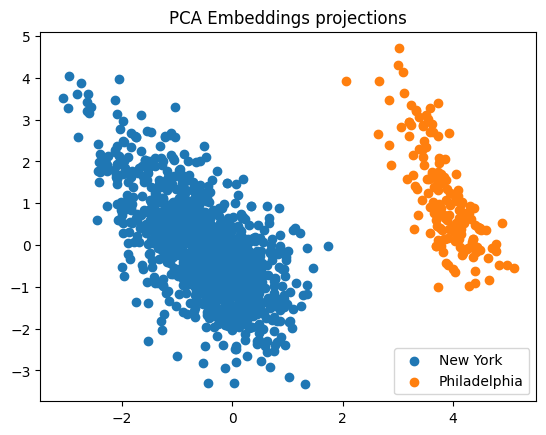

In [54]:
plt.scatter(X_pca[:len(embeddings1),0], X_pca[:len(embeddings1),1], label=TERM1)
plt.scatter(X_pca[len(embeddings1):,0], X_pca[len(embeddings1):,1], label=TERM2)
plt.legend()
plt.title("PCA Embeddings projections")

### UMAP

In [55]:
import umap

X_umap = umap.UMAP().fit_transform(all_embeddings)

Text(0.5, 1.0, 'UMAP Embeddings projections')

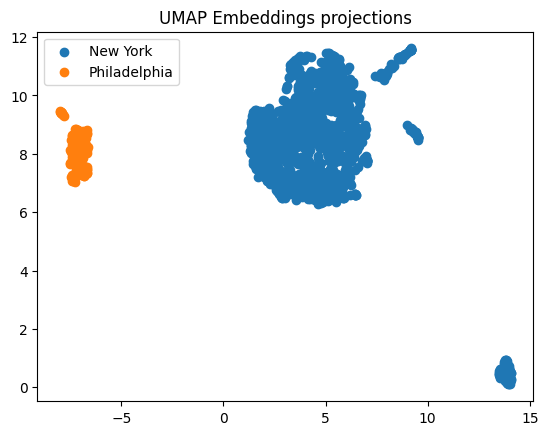

In [56]:
plt.scatter(X_umap[:len(embeddings1),0], X_umap[:len(embeddings1),1], label=TERM1)
plt.scatter(X_umap[len(embeddings1):,0], X_umap[len(embeddings1):,1], label=TERM2)
plt.legend()
plt.title("UMAP Embeddings projections")